# Navigation Project Solution


In [1]:
#import the unity enviroment
from unityagents import UnityEnvironment
#numpy as torch imput
import numpy as np
from collections import deque
#Be able to plot data
import matplotlib.pyplot as plt
#to save pytorch model
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. My implementation

I started using my solution to the dqn module and found might end up with more than 13 average score.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Below it can be found the code that will be used to train the agent. First pytorch choosen arquitecture and second agent definition

In [18]:
! cat model.py

#Used model from deep Q netwrok excercise with few modifications
#Import all torch necessary
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units= [64, 64]):
        """Initialize parameters and build model.
        Params
            state_size (int): Number of states
            action_size (int): Number of actions
            seed (int): Random seed
            fc1_units (int): Number of units in first hidden layer
            fc2_units (int): Number of units in second hidden layer
        """
        #allows us to access methods from base class
        super(QNetwork, self).__init__()
        #Set the seed in our neural net
        self.seed = torch.manual_seed(seed)
        #Fully connected layers from state (fc1) to actions (fc3)
        self.fc1 = nn.Linear(state_size, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
       

In [17]:
! cat dqn.py

import numpy as np
import random
from collections import namedtuple, deque

from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.0001             # learning rate, tried different learning rates and 0.0001 works best
UPDATE_EVERY = 5        # how often to update the network

#This will use GPU if found, otherwise will use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
            state_size (int): Number of states
            action_size (int): Number of actions
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size

Episode 100	Average Score: 0.47
Episode 200	Average Score: 3.61
Episode 300	Average Score: 6.91
Episode 400	Average Score: 7.87
Episode 500	Average Score: 11.90
Episode 600	Average Score: 13.14
Episode 700	Average Score: 14.68
Episode 800	Average Score: 14.27
Episode 900	Average Score: 15.26
Episode 1000	Average Score: 14.31
Episode 1100	Average Score: 14.73
Episode 1200	Average Score: 16.05
Episode 1300	Average Score: 16.22
Episode 1400	Average Score: 15.49
Episode 1500	Average Score: 15.95
Episode 1600	Average Score: 16.33
Episode 1700	Average Score: 16.45
Episode 1800	Average Score: 15.99
Episode 1900	Average Score: 15.28
Episode 2000	Average Score: 16.15


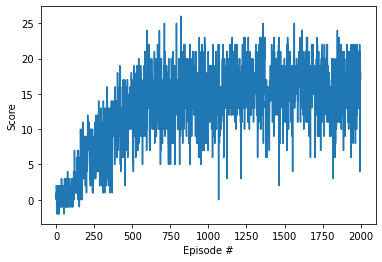

In [7]:
from dqn import Agent

agent = Agent(state_size=37, action_size=4, seed=12)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #This store scores from each episodes
    scores = []
    #Check last 100 scores as said finished 
    scores_window = deque(maxlen=100)  
    #How epsilon starts, remeber should start big and gradually decay
    eps = eps_start
    #Iterate through number of episodes
    for i_episode in range(1, n_episodes+1):
        #start
        env_reset = env.reset(train_mode = True)[brain_name]
        #state
        state = env_reset.vector_observations[0]
        #initialize score to 0
        score = 0
        #iterate through max number of trainings per episode
        for t in range(max_t):
            #return action 
            action = agent.act(state, eps)
            #take action
            env_reset = env.step(action)[brain_name]
            #store state produced by given action
            next_state = env_reset.vector_observations[0]
            #store reward
            reward = env_reset.rewards[0]
            #check if done
            done = env_reset.local_done[0]
            #learn through sampling Replay Buffer
            agent.step(state, action, reward, next_state, done)
            #Set next_state as state
            state = next_state
            #Add to score the reward
            score += reward
            #if done break
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### It took the agent around 600 episodes to get average reward of +13.
However I trained the agent over 2000 episodes to see how it improved.

In [12]:
from dqn import Agent
filename_to_load = 'checkpoint.pth'
final_eps = 0.05

agent = Agent(state_size=37, action_size=4, seed=12)
#load the saved model from previous training
agent.qnetwork_local.load_state_dict(torch.load(filename_to_load))

## Test trained model

In [13]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]           
score = 0                                         
while True:
    action = agent.act(state, eps=final_eps)      
    env_info = env.step(action)[brain_name]       
    next_state = env_info.vector_observations[0]  
    reward = env_info.rewards[0]                  
    done = env_info.local_done[0]                 
    score += reward                               
    state = next_state                            
    if done:
        print("Your final score is:")
        print(score)
        break

Your final score is:
19.0


In [14]:
env.close()

## Future Work
Future work might include usage of Double Q-Learning, to avoid over-estimation of action values. Another tool we can use is Prioritized experience replay, since we might loss important experience from the past. But also dueling networks that separate state values and state dependant actions, together with Distributional DQN and Noisy DQN. 
<br>
I also found, tunning the the neural netowrk end up in very different results, so, changing the learning rate, or different architecture migh help improving the average score. And throughout the course, changing the epsilon values might help as well. This two improvements might be very time consuming and not returning big scores as expected.